# Drydown Model Sample

The following is sample code to run a simple supply and demand drydown model on any dataset with soil moisture and precipitation information. 


Here it is set up to import a small chunk of MERRA2 data. The data has already been processed to only include the warm season (defined as the longest continuess time period without snowfall or snow coverage and temperatures greater than 0ºC). However, the code should work with any input data so long as you correctly identify the variable names. 


### Necessary Packages

In [1]:
import numpy as np
import pandas as pd
import xarray as xr

## for pointing at the relevant directories
from pathlib import Path

## progress bars for loops
from tqdm.notebook import tqdm  

## because i have an aversion to underscores and this cleans up a class ~so much~ 
from dataclasses import dataclass, field

## for checking if files exist
from os.path import exists

## for model calculation
from scipy.optimize import least_squares
from sklearn.metrics import r2_score


## for plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.dates as mdates
import cartopy.feature as cfeature




### Drydown Model Class

In [2]:
@dataclass
class DrydownModel:
    t: np.ndarray
    P_values: np.ndarray
    M_obs: np.ndarray
    lambda_guess: float 
    a_guess: float 
        
    M_pred: np.ndarray = field(default = None, init = False)
    
    def euler_method(self, t, P_values, M_obs, lam, a):
        '''
        Using Euler's method to solve the ODE
        
        Args:
            t (array):        Time array.
            P_values (array): Precipitation values.
            lam (float):      lambda parameter. Time to drydown to 0 after precipitation 
            a (float):        alpha parameter. Amount of precipitation that infuses into the soil moisture layer.
        
        Returns:
            array: Predicted soil moisture values.

        Code & math information: 
        ### code help: https://pythonnumericalmethods.studentorg.berkeley.edu/notebooks/chapter22.03-The-Euler-Method.html
        ### math help: https://math.libretexts.org/Courses/Monroe_Community_College/MTH_225_Differential_Equations/03%3A_Numerical_Methods/3.01%3A_Euler's_Method
        
        '''
        
        M_pred = np.zeros(len(t))
        M_init = M_obs[0]
        M_pred[0] = M_init
        
        for i in range(1, len(t)):
            dt = t[i] - t[i-1]
            
            dM_dt = a * P_values[i-1] - M_pred[i-1] / lam
            M_pred[i] = M_pred[i-1] + dM_dt * dt
            
            
        return M_pred
    

    def objective(self, params):
        """
        Objective function --> optimization to minimize residuals.

        Args:
            params (array): Parameters to optimize (lam and a).

        Returns:
            array: Residuals between observed and predicted values.
        """

        lam = np.exp(params[0])
        a = np.exp(params[1])

        self.M_pred = self.euler_method(self.t, self.P_values, self.M_obs, lam, a)

        residuals = self.M_obs - self.M_pred
        
        return residuals 
    
    def fit_params(self):
        '''
        Fit lambda and a using scipy.optimize.least_squares

        Returns:
            tuple: fitted lam and a parameters
        '''
        initial_guess = np.log([self.lambda_guess, self.a_guess])
        bounds = (np.log([1e-3, 1e-3]), np.log([1e3, 1e0]))

        ## commented out code describes other method options
        result = least_squares(self.objective, initial_guess, bounds=bounds,
                               ## method = 'trf' : "Trust Region Reflective algorithm, 
                               ## particularly suitable for large sparse problems with bounds. 
                               ## Generally robust method."
                               method='trf', ftol=1e-8, xtol=1e-8)
                               ##method = 'lm')
                               ## Levenberg-Marquardt algorithm as implemented in MINPACK. 
                               ## Doesn’t handle bounds and sparse Jacobians. Usually the 
                               ## most efficient method for small unconstrained problems.
                               #method = 'lm', ftol = 1e-8, xtol=1e-8)
        
        fitted_params = np.exp(result.x)
        return fitted_params

    def calculate_r2(self):
        """
        Calculate the R² value of the model fit.

        Returns:
            float: R² value.
        """
        if self.M_pred is None:
            raise ValueError("Predicted values M_pred are not available. Run fit_params first.")
        return r2_score(self.M_obs, self.M_pred)

### Defining drydown:

A sensible definition of drydown time might be the time it takes for the soil to return to its initial state $M_0$.  In that case, the drydown time would be
$$\tau =\lambda \ln (1+\alpha/M_0 ).$$
If $\lambda = 100$, for example, it would take 9.5 days for the soil to return to its previous value after increasing by 10\% and 40 days if it increased by 50\%.  These are huge values, though: the maximum day-to-day increase in soil moisture in the MIROC model is about 6\%.  For small x $\ln(1+x) \approx x$ so the drydown time is  $$\tau \approx \frac{\alpha}{M_0}\lambda = \frac{A P}{M_0} \lambda.$$
This makes physical sense: heavy precipitation should moisten the soil more and take longer to dry out.  The drier the soil is to begin with, the longer it will take to return to this ``normal" value.  The drydown time depends on the fraction $A$ of precipitation that gets absorbed by the soil: obviously, if more precip goes to runoff, there will be less in the soil to dry out.

In [3]:
def drydown_params(ds, model, model_params, lambda_guess, a_guess, 
                   debug=False, printout = False, return_M_pred=False):
    """
    Fit the drydown model parameters for the given dataset.

    Args:
        ds (xarray.Dataset): Input dataset containing precipitation and soil moisture data.
        ds_clime: climatology for precipitation and soil moisture data
        model: dataset and/or model name to determine variable names
        model_params: parameters for dataset and/or model 
        lambda_guess (float): Initial guess for lambda parameter.
        a_guess (float, optional): Initial guess for a parameter.
        model_version (str): Version of the model ('v1', 'v2', or 'v3').
        debug (bool): Print debug information if True.
        printout (bool): Print the results if True.

    Returns:
        tuple: Fitted parameters, drydown time, and R² value.
    """

    p_var = model_params[model]['p_var']
    s_var = model_params[model]['s_var']

    P = ds[p_var].data
    M = ds[s_var].data
    t = np.linspace(0, len(M)-1, len(M))

    if debug == True:
        print(f"Length of P: {len(P)}, Length of M: {len(M)}, Length of t: {len(t)}")
        print(f"First 10 M values: {M[:10]}")  

    # Initialize model with parameter guesses
    model = DrydownModel(t, P, M, lambda_guess, a_guess)
    fitted_params = model.fit_params()
    
    # Unpack fitted parameters 
    fitted_lambda, fitted_a = fitted_params
    
    M_predicted = model.M_pred

    r2 = model.calculate_r2()


    p_div_m = ds['mean_p_div_m'].data
    ## tau = lambda * np.log(1 + a * seasonal_P_mean/seasonal_M_mean)
    tau = fitted_lambda * np.log(1 + (fitted_a * p_div_m))

     # Print output if requested
    if printout:
        print(f"lambda: {fitted_lambda}")
        print(f"a: {fitted_a}")
        print(f"R²: {r2}")
        print(f"tau (drydown): {tau}")

    # Return results with flexibility for M_pred if requested
    if return_M_pred:
        return tau, fitted_lambda, fitted_a, r2, M_predicted
    else:
        return tau, fitted_lambda, fitted_a, r2

### Import data

The dictionary can be expanded to include multiple datasets

In [4]:
dict_ds = {'MERRA2': {}}

In [5]:
model_params = {
   'MERRA2': {
       'filename':      'MERRA2_warm-season_2000-2008.nc', 
       'p_var':         'PRECTOTLAND',
       't_var':         'T2MMEAN', 
       'sf_var':        'SFMC',
       'rz_var':        'RZMC',
       'snowfall_var':  'PRECSNOLAND', 
       'snowdepth_var': 'SNODP', 
       'model_name':    'MERRA-2'
   } 
}

Choose surface or rootzone for primary soil moisture variable:

In [6]:
for model in model_params.keys():
    model_params[model]['s_var'] = model_params[model]['sf_var']

In [7]:
# define project root (where this .ipynb lives and then up one directory level)
project_root = Path.cwd().parent

# point to directory with data 
processed_data_dir = f'{project_root}/processed-data/'

In [8]:
for model in tqdm(dict_ds.keys()):
    print(model)

    ### open seasonal dataset(s) 
    dict_ds[model] = xr.open_mfdataset(f"{processed_data_dir}{model_params[model]['filename']}", 
                         parallel = True).load()


    ### calculate typical moisture infusion for the entire time period 
    dict_ds[model]['mean_p_div_m'] = (dict_ds[model][model_params[model]['p_var']]/dict_ds[model][model_params[model]['s_var']]).mean(dim = 'time')
    dict_ds[model]['median_p_div_m'] = (dict_ds[model][model_params[model]['p_var']]/dict_ds[model][model_params[model]['s_var']]).median(dim = 'time')

    

  0%|          | 0/1 [00:00<?, ?it/s]

MERRA2


## Single Gridcell 

Runs the drydown model on a single gridcell

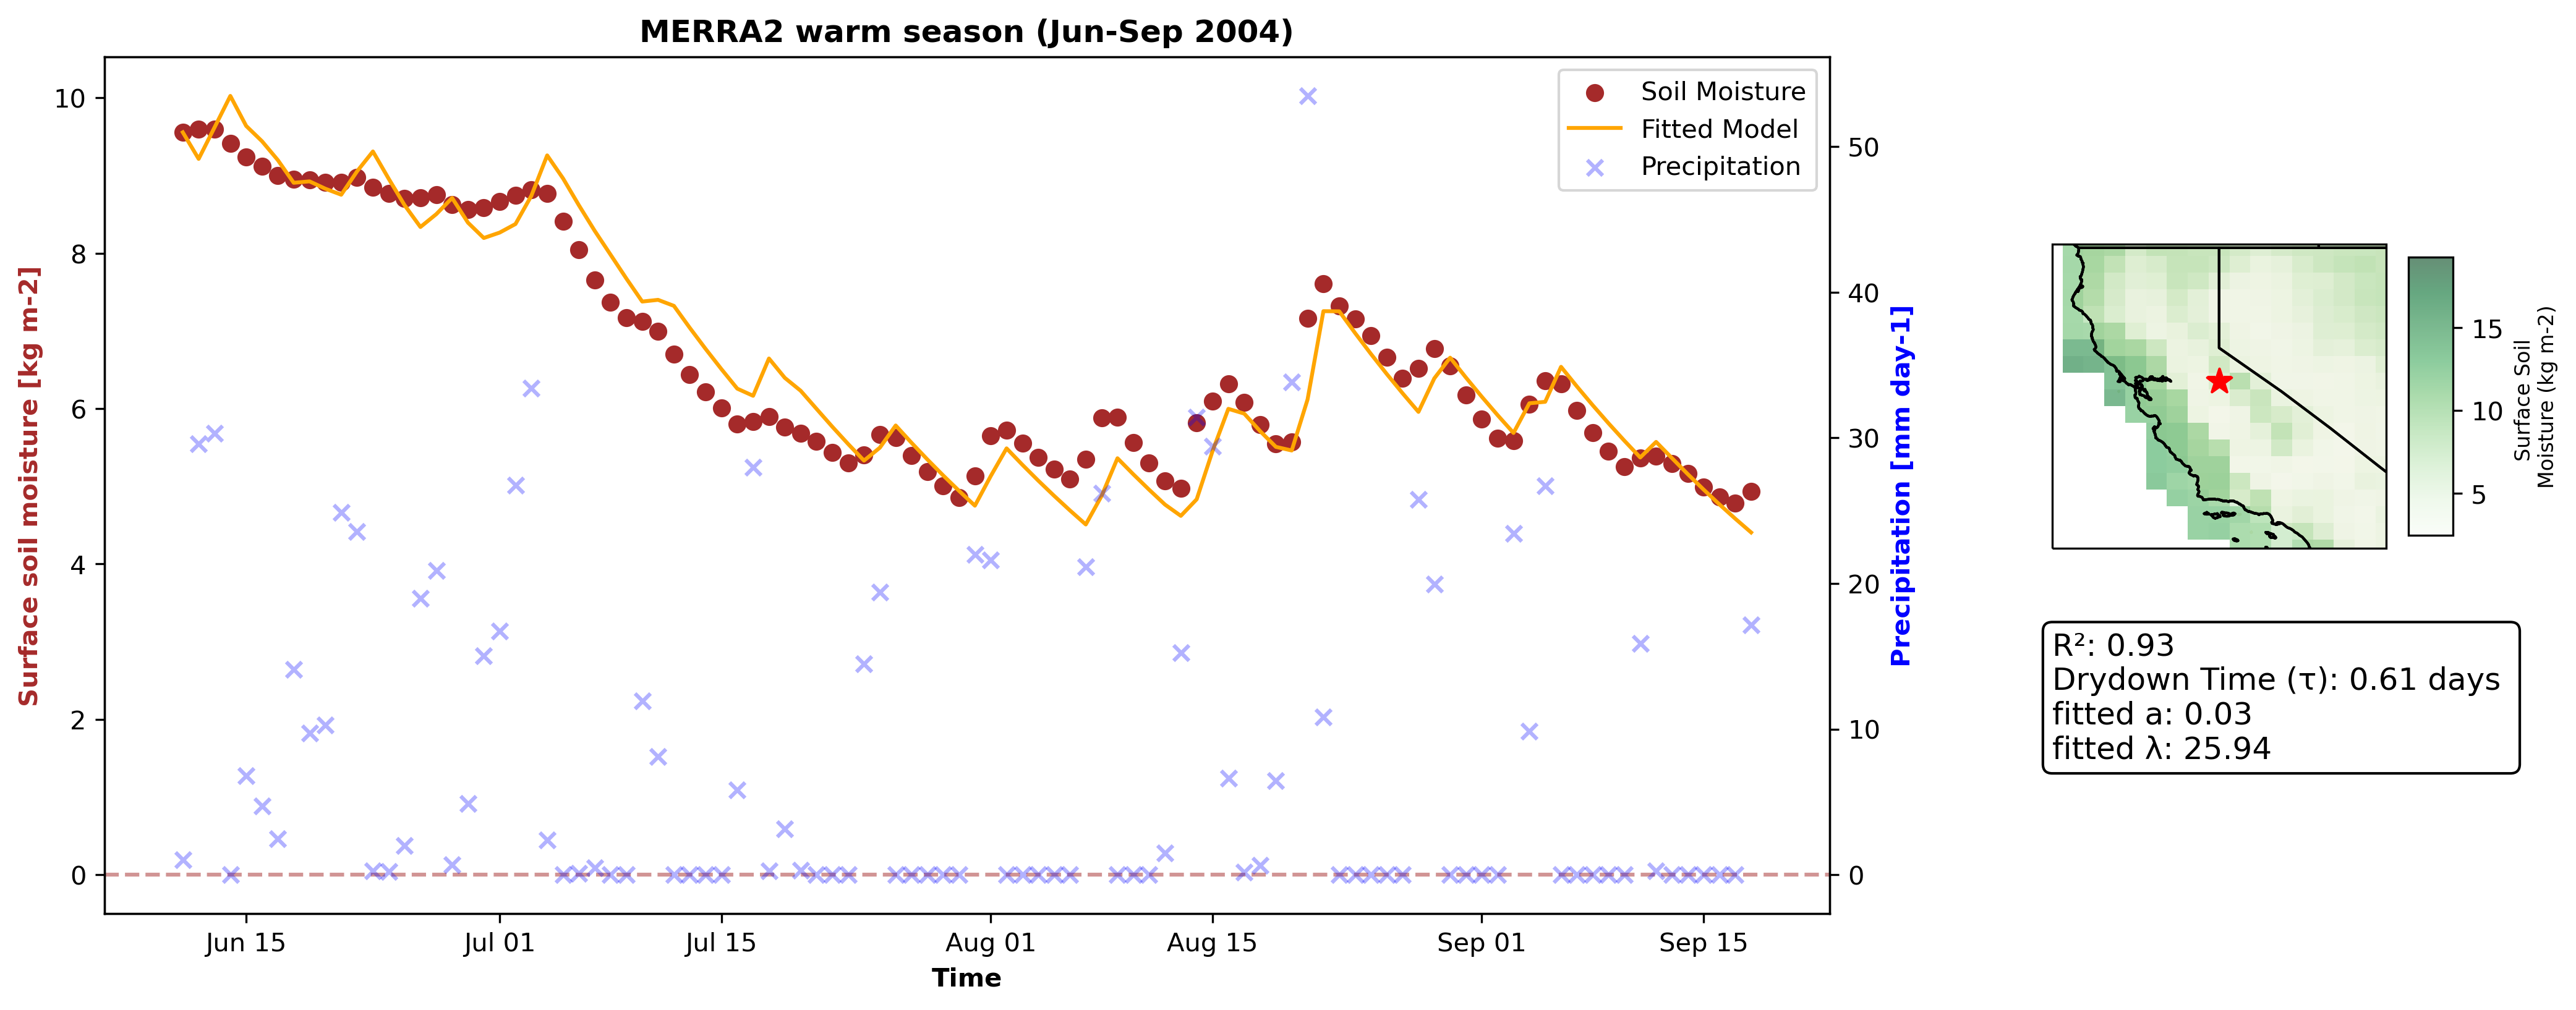

In [9]:
model = 'MERRA2'
lat, lon  = 38, -120
year = '2004'
lambda_guess = 200
a_guess = 0.01

if 'year' in dict_ds[model].dims:
    ds = dict_ds[model].sel(time = year).sel(year = int(year)).sel(lat = lat, lon = lon, method = 'nearest').dropna(dim="time", how="any")  # Drops NaN values along time dimension
else: 
    ds = dict_ds[model].sel(time = year).sel(lat = lat, lon = lon, method = 'nearest').dropna(dim="time", how="any")  # Drops NaN values along time dimension

tau, fitted_lambda, fitted_a, r2, M_predicted = drydown_params(ds, model, model_params, lambda_guess, a_guess, debug=False, printout = False, return_M_pred=True)

ds['M_predicted'] = ('time', M_predicted)



fig, ax1 = plt.subplots(figsize = (12,6), dpi=300)

lns1 = ds[model_params[model]['s_var']].plot.scatter(x = 'time', marker = 'o', label='Soil Moisture', color='brown', ax = ax1)
lns2 = ds['M_predicted'].plot(label='Fitted Model', color='orange', ax = ax1)

ax1.set_ylabel('Surface soil moisture [' + ds[model_params[model]['s_var']].units + ']', color='brown', weight='bold')
ax1.axhline(y=0, linestyle='--', color='brown', alpha=0.5)
ax1.set_title(None)

## add precipitation on a secondary axis
ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis
lns3 = ds[model_params[model]['p_var']].plot.scatter(x = 'time', marker ='x', label='Precipitation', color='blue', alpha=0.3, ax = ax2)

ax2.set_ylabel('Precipitation [' + ds[model_params[model]['p_var']].units + ']', color='blue',  weight='bold')
ax2.set_title(None)

# make a legend for both axis
lns = [lns1, lns2[0], lns3]
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)

ax1.set_xlabel('Time', weight='bold')

#ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(1,12,3)))
# you can change the format of the label (now it is 2016-Jan)  
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.setp(ax1.get_xticklabels(), rotation=0) 

for label in ax1.get_xticklabels():
    label.set_horizontalalignment('center')


plt.title(f'{model} warm season ({ds.time[0].dt.strftime("%b").data}-{ds.time[-1].dt.strftime("%b %Y").data})', weight = 'bold')

divider = 0.3  # Adjust this ratio as needed

# Add the map on another axes
map_ax = fig.add_axes([1, 0.4, 0.15, 0.35], projection=ccrs.PlateCarree())   # [left, bottom, width, height]
## if extent for the entire dataset
#map_ax.set_extent([dict_ds[model].lon.min(), dict_ds[model].lon.max(), dict_ds[model].lat.min(), dict_ds[model].lat.max()], crs=ccrs.PlateCarree())
## if extent zoomed in for specific pixels
map_ax.set_extent([-125, -115, 33, 42.1], crs=ccrs.PlateCarree())

map_ax.coastlines('10m')
map_ax.add_feature(cfeature.LAND)
map_ax.add_feature(cfeature.COASTLINE)
map_ax.add_feature(cfeature.STATES)

lon_star = ds.lon.data
lat_star = ds.lat.data

## plot spatial data for reference
im = dict_ds[model][model_params[model]['s_var']].sel(time = year).median(dim='time').plot(
    ax=map_ax, alpha=0.6, cmap='Greens', 
    add_colorbar=False, 
)
map_ax.scatter(lon_star, lat_star, color='red', marker='*', s=100)

# add the colorbar and shrink it to be roughly the size of the plot  
cbar_ax = fig.add_axes([1.16, 0.45, 0.02, 0.25])  # [left, bottom, width, height]
cb = plt.colorbar(im, cax=cbar_ax)
cb.set_label(f"Surface Soil \nMoisture ({ds[model_params[model]['s_var']].attrs['units']})", size = 8)

map_ax.set_xlabel('Longitude')
map_ax.set_ylabel('Latitude')

#tau, fitted_lambda, fitted_a, r2,
# **Add Text Box Below Map**
fig.text(1, 0.25, f"R²: {r2:.2f}\nDrydown Time (τ): {np.round(tau,2)} days \nfitted a: {np.round(fitted_a, 2)} \nfitted λ: {np.round(fitted_lambda, 2)}",
         fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))


plt.show()

## Process entire dataset

This is... not very efficient. Currently it loops through every available single lat/lon pair. This should probably be some kind of ufunc.

Currently: 40 years of MERRA2 in Western North America takes ~15 minutes


In [10]:
def process_all_grid_points(ds_model, model, lambda_guess, a_guess):
    """
    Process all grid points in the dataset and fit the drydown model.

    Args:
        ds_region (xarray.Dataset): Input dataset.
        lambda_guess (float): Initial guess for lambda parameter.
        a_guess (float, optional): Initial guess for a parameter.
        model_version (str): Version of the model ('v1', 'v2', or 'v3'). <- not implemented ~ for future work
    Returns:
        xarray.Dataset: Dataset with fitted parameters and metrics.
    """
    results = []

    for year in tqdm(np.unique(ds_model['time.year'])):
        stacked_ds = ds_model.stack(points = ('lat', 'lon')).sel(time = str(year)).copy()
    
        for point in stacked_ds.points:
            lat, lon = point.item()
            if 'year' in stacked_ds.dims:
                ds = stacked_ds.sel(points=point).dropna(dim="time", how="any").sel(year = year)
            else:
                ds = stacked_ds.sel(points=point).dropna(dim = 'time', how = 'any')
            
            try: 
                length_of_season = len(ds.time)
                tau, fitted_lambda, fitted_a, r2 = drydown_params(ds, model, model_params, lambda_guess, a_guess)
                results.append((lat, lon, tau, fitted_lambda, fitted_a, ds['time.year'][0].item(), r2, length_of_season))
            except Exception:
                ## uncomment to except error 
                # traceback.print_exc()
                # print(f'({year}: {lat}, {lon}) failed')
                pass


    return convert_results_to_xarray(results)

def convert_results_to_xarray(results):
    """
    Convert results into an xarray.Dataset.

    Args:
        results (list of tuples):  List of results from processing grid points.

    Returns:
        xarray.Dataset: Dataset with fitted parameters and metrics.
    """
    ## extract results into separate lists
    ## only use lats, lons, and years from this 
    lats, lons, tau_vals, a_vals, drydown_vals, years, r2_vals, length_of_season = zip(*results)

    unique_lats = np.unique(lats)
    unique_lons = np.unique(lons)
    unique_years = np.unique(years)
    
    ## create xarray dataset
    ds = xr.Dataset({
        'fitted_lambda':    (['lat', 'lon', 'year'], 
                             np.full((len(unique_lats), len(unique_lons), len(unique_years)), np.nan)),
        'fitted_a':         (['lat', 'lon', 'year'], 
                             np.full((len(unique_lats), len(unique_lons), len(unique_years)), np.nan)),
        'tau':              (['lat', 'lon', 'year'], 
                             np.full((len(unique_lats), len(unique_lons), len(unique_years)), np.nan)),
        'r2':               (['lat', 'lon', 'year'], 
                             np.full((len(unique_lats), len(unique_lons), len(unique_years)), np.nan)),
        'length_of_season': (['lat', 'lon', 'year'], 
                             np.full((len(unique_lats), len(unique_lons), len(unique_years)), np.nan))

    }, coords={
        'lat': unique_lats,
        'lon': unique_lons,
        'year': unique_years,
    })

    for lat, lon, tau, lam, a, year, r2, season_length in results:

        lat_idx = np.where(unique_lats == lat)[0][0]
        lon_idx = np.where(unique_lons == lon)[0][0]
        year_idx = np.where(unique_years == year)[0][0]
        
        ds['fitted_lambda'].loc[dict(lat=lat, lon=lon, year=year)] = lam
        ds['fitted_a'].loc[dict(lat=lat, lon=lon, year=year)] = a

        ds['tau'].loc[dict(lat=lat, lon=lon, year=year)] = tau
        ds['r2'].loc[dict(lat=lat, lon=lon, year=year)] = r2
        
        ds['length_of_season'].loc[dict(lat = lat, lon = lon, year = year)] = season_length
        
        ds['fitted_lambda'].attrs['units'] = 'days'
        ds['tau'].attrs['units'] = 'days'
        ds['length_of_season'].attrs['units'] = 'days'
        
    return ds
    

In [11]:
dict_processed = {}

for model in tqdm(dict_ds.keys()):
    ## save file for processed dataset, if it exists, import, otherwise process anew
    fname = f"{processed_data_dir}{model}_warm_season_drydown_model_results.nc"
    if exists(fname):
        print(f'drydown results for {model} already exist, importing')
        ## open dataset
        dict_processed[model] = xr.open_dataset(fname, decode_times = False)
    else: 
        print(f'processing {model} drydown results')
        ds_model = dict_ds[model]
        dict_processed[model] = process_all_grid_points(ds_model, model, lambda_guess, a_guess)
        dict_processed[model].to_netcdf(fname)

  0%|          | 0/1 [00:00<?, ?it/s]

processing MERRA2 drydown results


  0%|          | 0/9 [00:00<?, ?it/s]

## Expando-plots

Looks at the model output for any number of datasets (be reasonable)

In [12]:
def expando_plot(dictionary, var, var_name, average = 'median'):
    cols = len(dictionary.keys())

    fig, axes = plt.subplots(1, cols, figsize=(cols*5, cols*5), 
                             subplot_kw={"projection": ccrs.PlateCarree()}, dpi=300)
    
    ## Use the same extent for all plots
    shared_extent = [-125, -100, 25, 49.2]  # [lon_min, lon_max, lat_min, lat_max]
    
    ## plot handles for colorbar
    plot_handles = []

    model_list = list(dictionary.keys())
    
    drydown_params = {'levels': 9, 
                      'cmap': 'YlGn',
                      #'cmap': 'viridis_r',
                      #'cmap': 'BrBG',
                      'vmin': 0, 
                      'vmax': 1.6, 
                      #'vmax': 4,
                      'unit': 'days'}
    
    r2_params = {'levels': 11, 
                 'cmap': 'magma',
                 'vmin': 0, 
                 'vmax': 1,  
                 'unit': None,
                 'ticks': [0, 0.2, 0.4, 0.6, 0.8, 1.0],
                 'labels': [0, 0.2, 0.4, 0.6, 0.8, 1.0], 
                }

    season_length_params = {'levels': 13, 
                            #'cmap': 'viridis',
                            'cmap': 'Oranges',
                            'vmin': 0, 'vmax': 360,
                            'unit': 'days',
                            'ticks': [0, 60, 120,  180,  240,  300,  360],
                            'labels':[0, 60, 120,  180,  240,  300,  360]}

    if 'tau' in var:
    #if var == 'tau':
        cmin = drydown_params['vmin']
        cmax = drydown_params['vmax']
        levels = drydown_params['levels']
        unit = drydown_params['unit']
        cmap = drydown_params['cmap']
        ticks = None
        labels = None
    
    
    elif var == 'r2':
        cmin = r2_params['vmin']
        cmax = r2_params['vmax']
        levels = r2_params['levels']
        unit = r2_params['unit']
        cmap = r2_params['cmap']
        ticks = None
        labels = None

    elif (var == 'length_of_season') :
        cmap = season_length_params['cmap']
        levels = season_length_params['levels']
        cmin = season_length_params['vmin']; cmax = season_length_params['vmax']
        ticks = season_length_params['ticks']
        labels = season_length_params['labels']
        unit = season_length_params['unit']

    elif var == 'fitted_a':
        cmin = r2_params['vmin']
        cmax = r2_params['vmax']
        levels = r2_params['levels']
        unit = r2_params['unit']
        cmap = 'BuPu'
        ticks = None
        labels = None

    elif var == 'fitted_lambda':
        cmin = drydown_params['vmin']
        cmax = 400
        levels = drydown_params['levels']
        unit = drydown_params['unit']
        cmap = drydown_params['cmap']
        ticks = None
        labels = None

    else:
        cmin = None
        cmax = None
        levels = 9
        unit = None
        cmap = 'Greens'
        ticks = None
        labels = None 

    j = 0 
    for model_name, model in dictionary.items():
        if cols == 1:
            ax = axes
        else: 
            # interate through subplots
            ax = axes[j]  

        if average == 'mean':
            # Plot the slope on the current axis
            plot_handle = model[var].mean(dim='year').plot(
                ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False, 
                cmap = cmap,
                levels=levels, 
                vmin=cmin, vmax=cmax
            )
        if average == 'median':
            plot_handle = model[var].median(dim='year').plot(
                ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False, 
                cmap = cmap,
                levels=levels, 
                vmin=cmin, vmax=cmax
            )
            
        plot_handles.append(plot_handle)  # Store the plot handle for colorbar
        
        ax.set_title(model_params[model_name]['model_name'], fontweight='bold')
        
        # Add map features
        ax.set_extent(shared_extent, crs=ccrs.PlateCarree())  # Apply the shared extent
    
        ax.coastlines('10m')
        ax.add_feature(cfeature.COASTLINE)
        ax.add_feature(cfeature.STATES)
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        ax.add_feature(cfeature.LAND, edgecolor='black')
    
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
    
        # Subplot lettering from Kevin S
        # ax.text(0.01, 0.98, string.ascii_letters[model_list.index(model_name)] + '.',
        #         transform=ax.transAxes, ha='left', va='top',
        #         fontsize=18, fontweight='bold',
        #         bbox={'boxstyle': 'round',
        #               'facecolor': 'white',
        #               'alpha': 0.8,
        #               'edgecolor': 'None',
        #               'pad': 0.2})
    
        # Set gridlines labels only on left and bottom
        gl.top_labels = False
        gl.right_labels = False

        # Show latitude labels only on the first subplot
        if j == 0:
            gl.left_labels = True
        else:
            gl.left_labels = False

        j+=1
        
        #if ('tau', 'fitted_a', 'fitted_lambda') in var:
        if any(v in var for v in ('tau', 'fitted_a', 'fitted_lambda')):
            # Define where to apply hatch marks
            # hashing where r2 < 0.6
            low_r2_mask = model['r2'].median(dim = 'year') < 0.5
            ax.contourf(
                low_r2_mask.lon, low_r2_mask.lat, low_r2_mask.astype(int), 
                levels=[-0.5, 0.5, 1.5],
                hatches=['', '////'],  # '////' creates angled hash lines
                #hatches=['', 'xx'],
                #hatches=['', '\\\\'],
                colors='none',  # Transparent fill
                transform=ccrs.PlateCarree(),
                zorder=5
            )
    
    
    # Add the shared colorbar
    cbar = fig.colorbar(plot_handles[0], ax=axes, orientation='horizontal', fraction=0.03, pad=0.05)
   
    # if '_' in var:
    #     var_name = var.replace("_", " ")

    # elif 'season' in var:
    #     var_name = 'length of warm season'

    # elif 'r2' in var:
    #     var_name = 'R$^2$'
        
    # else:
    #     var_name = var


    # if 'tau' in var:
    #     #var_name = 'drydown'
    #     var_name = 'τ, drydown'
    
    # Label the colorbar
    if unit == None:
        cbar.set_label(f'median {var_name}', fontsize=14, labelpad=10)  

    else: 
        cbar.set_label(f'median {var_name} ({unit})', fontsize=14, labelpad=10)  

    
    if (ticks is not None) & (labels is not None):        
        cbar.set_ticks(ticks = ticks, labels = labels)

    #fig.savefig(f'{fig_save_dir}tri_plot_{var}.png', bbox_inches='tight')

    plt.show()

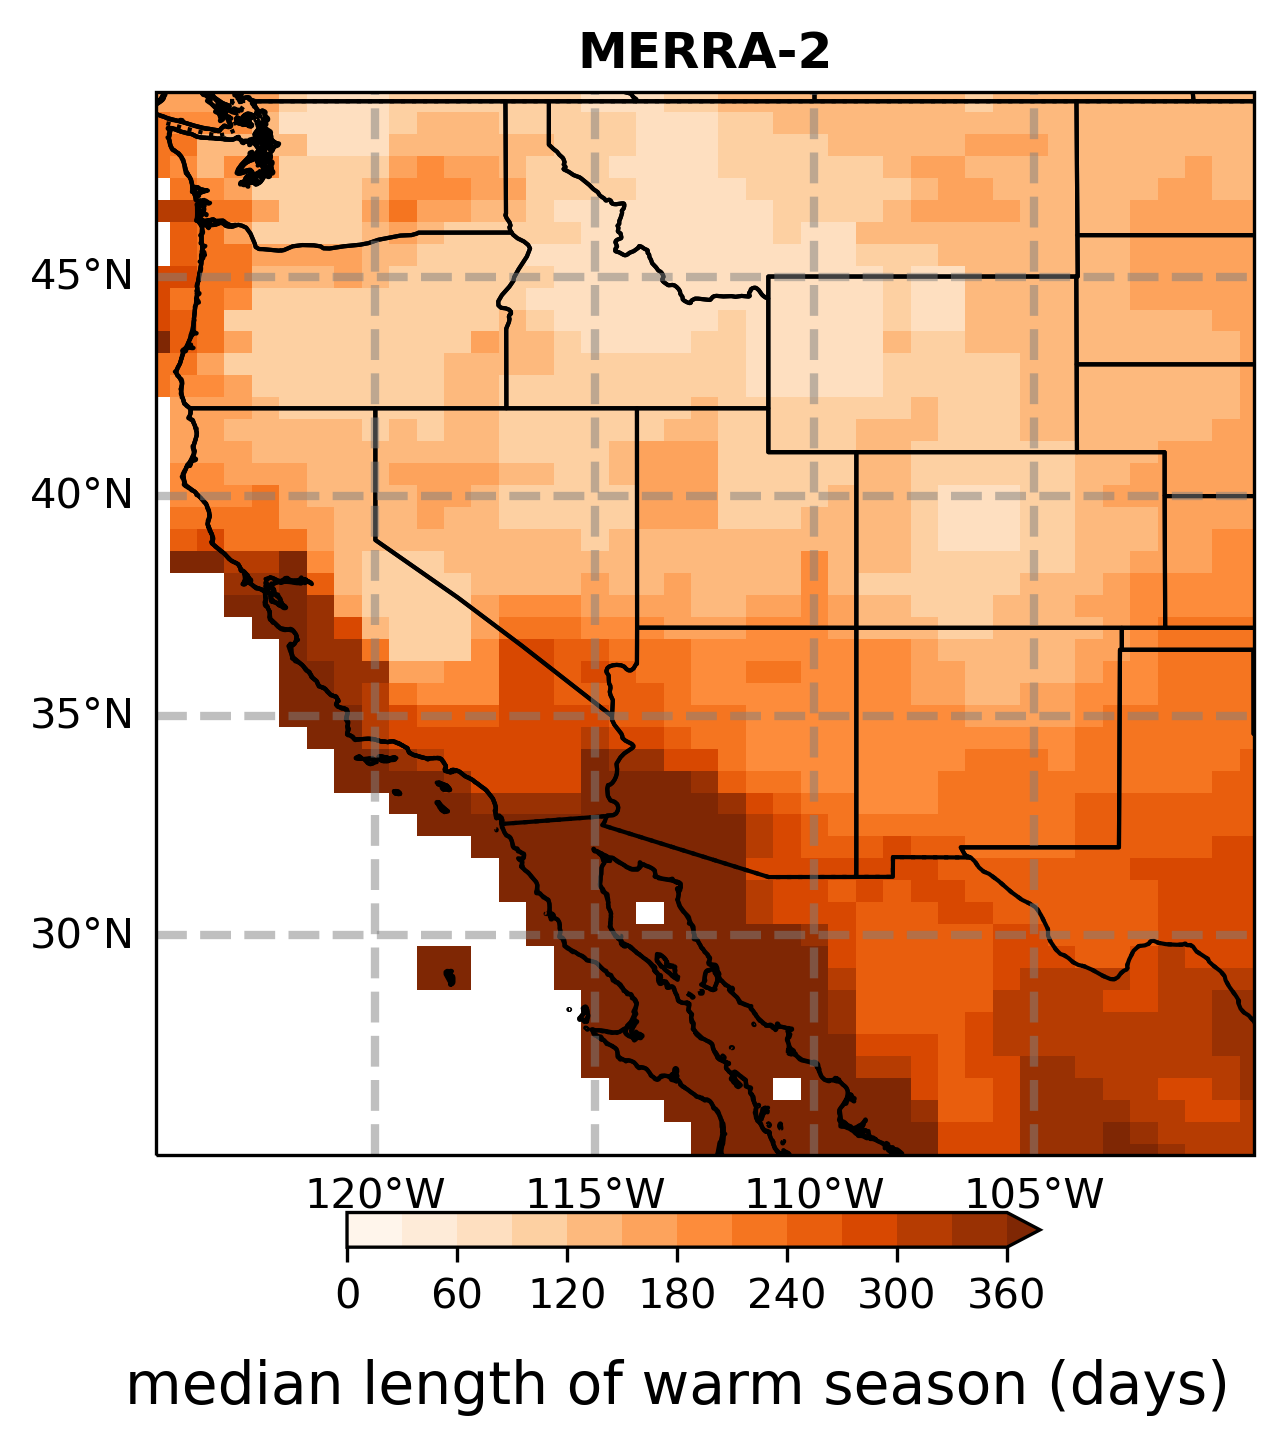

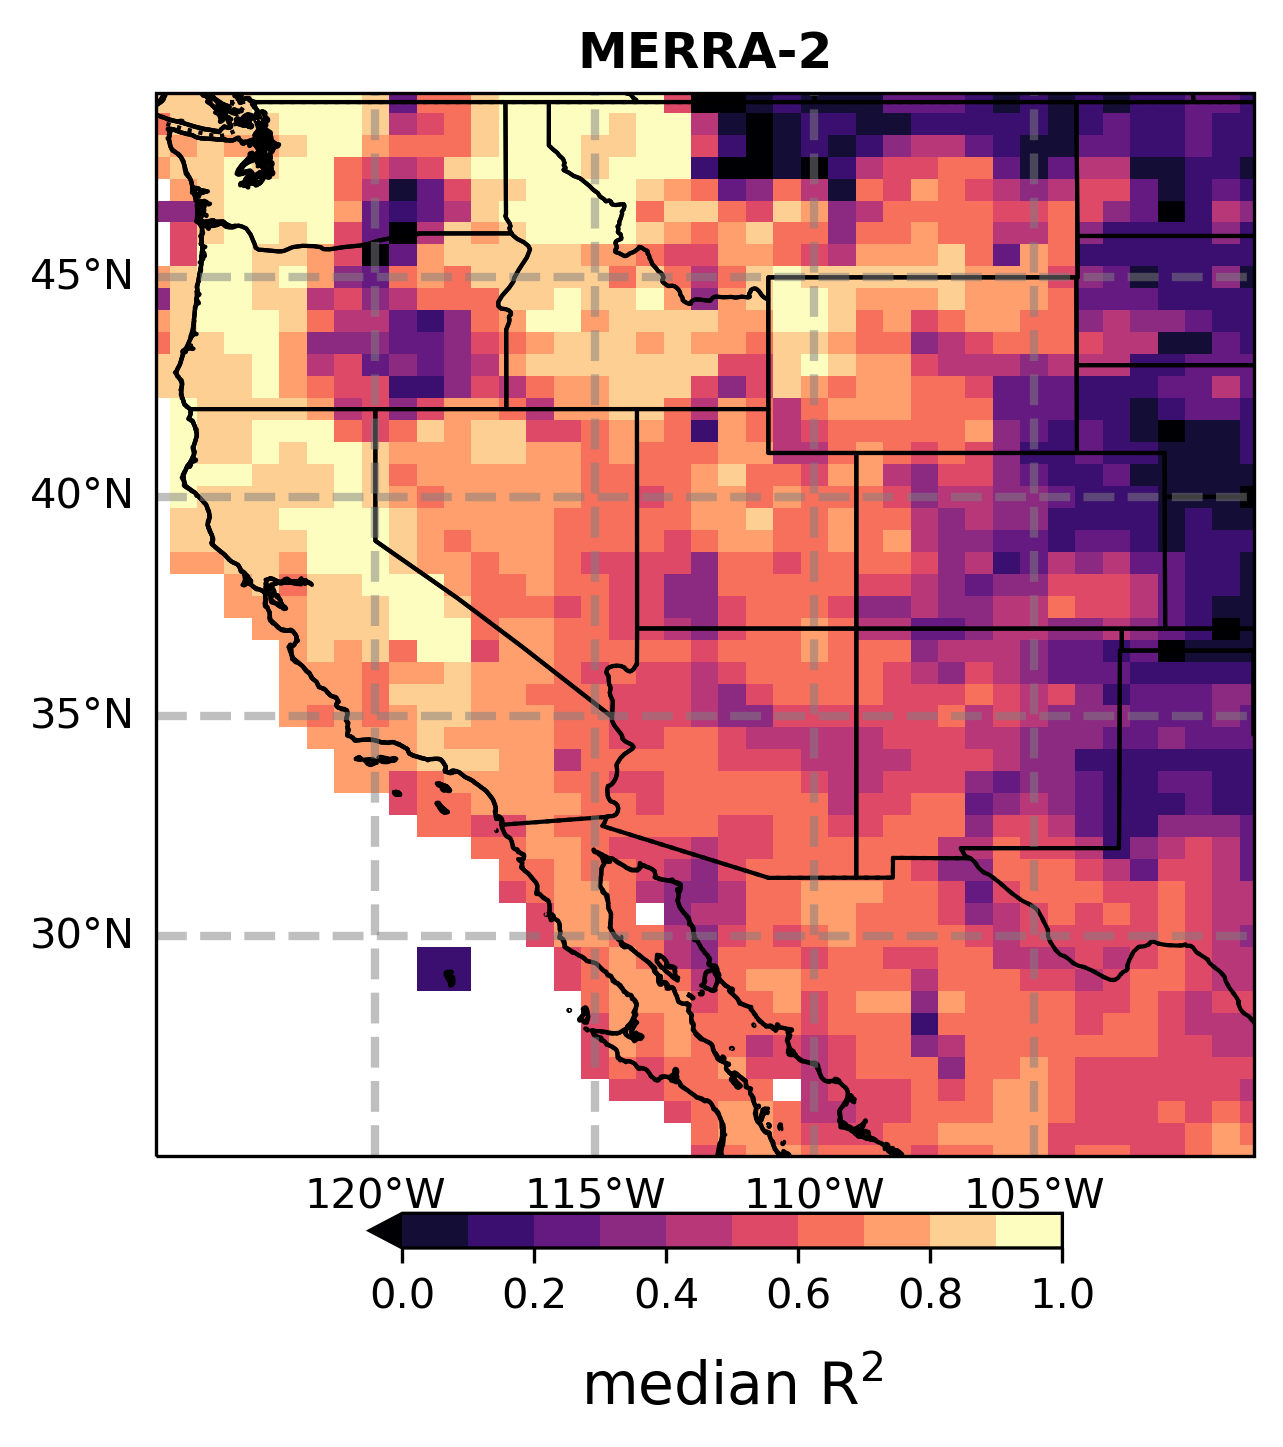

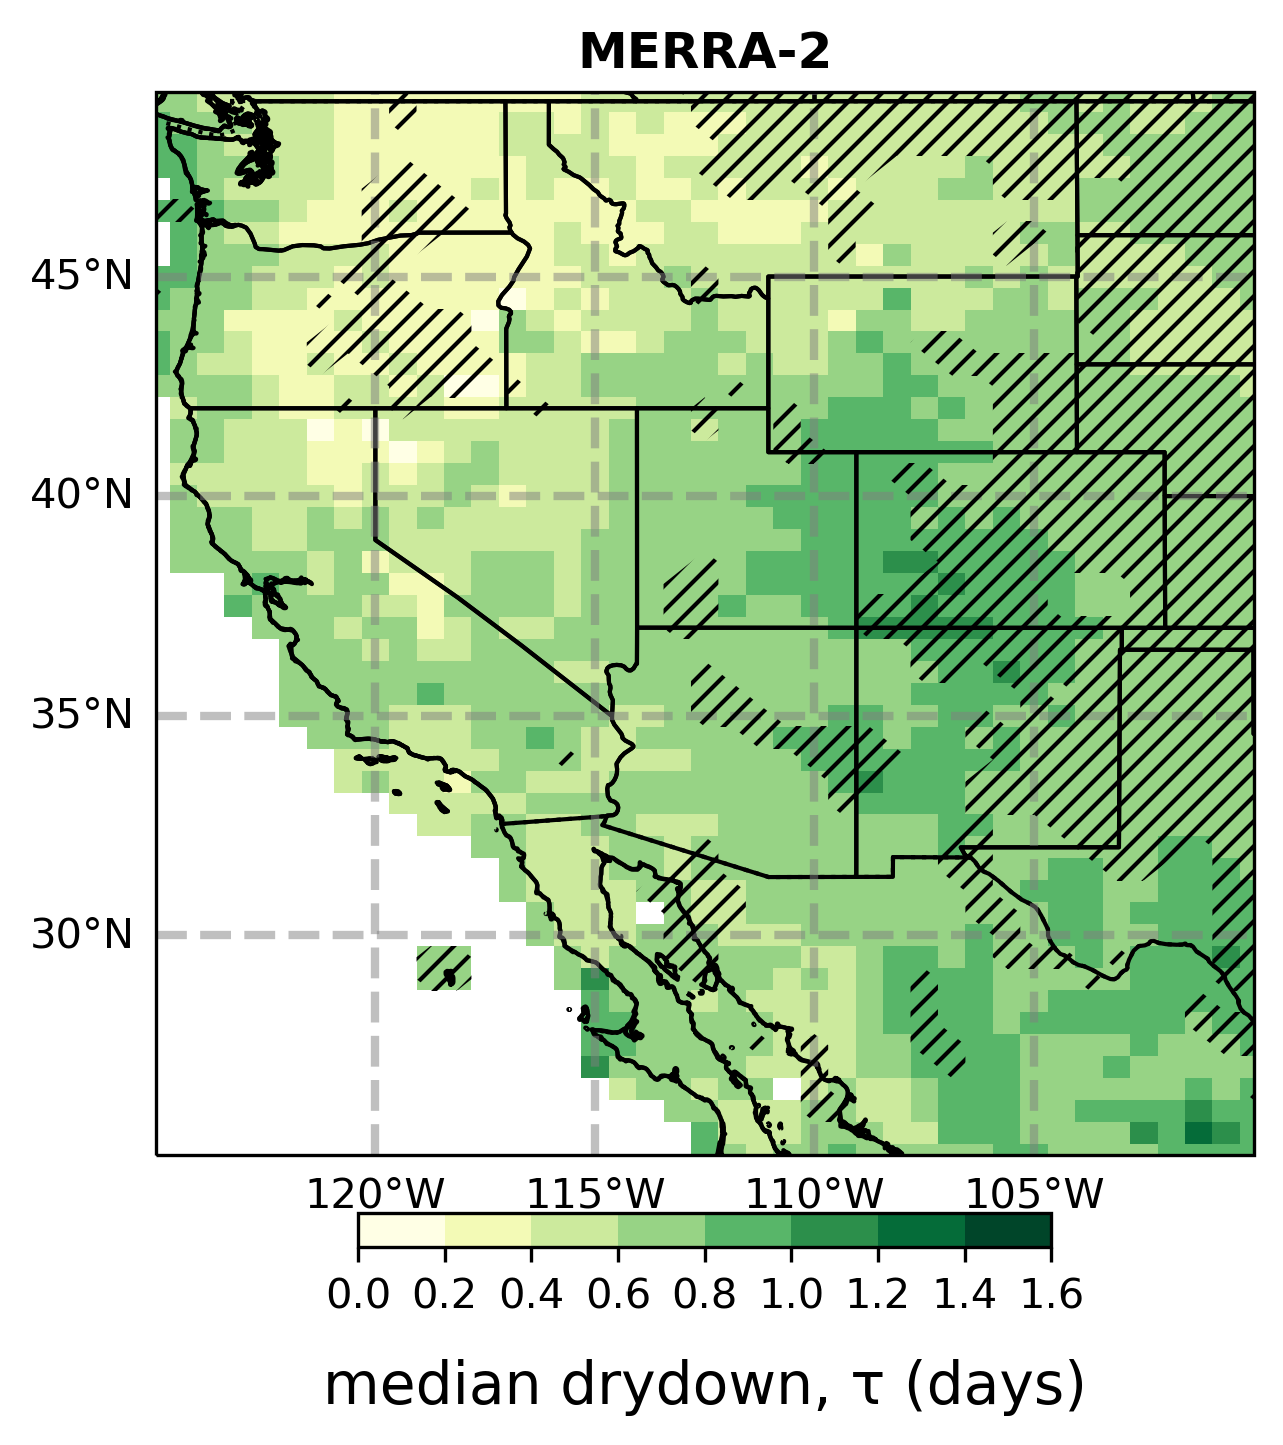

In [14]:
expando_plot(dict_processed, 'length_of_season', 'length of warm season')
expando_plot(dict_processed, 'r2', 'R$^2$')
expando_plot(dict_processed, 'tau', 'drydown, τ')
#expando_plot(dict_processed, 'fitted_lambda', '$\lambda$')
#expando_plot(dict_processed, 'fitted_a', 'a')